<a href="https://colab.research.google.com/github/thanhtrinh2003/GarbageClassificationKaggle/blob/main/Resnet_Kaggle_Notebook_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def list_dataset():
    for dirname, _, filenames in os.walk('/content/drive/MyDrive/Lumiere 2021/Code/Garbage classification/'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

            
# Add class name prefix to each path based on class name include in filename
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df


def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]

IMAGES_DIR = '/content/drive/MyDrive/Lumiere 2021/Code/Garbage classification/'
    
train_file = '/content/drive/MyDrive/Lumiere 2021/Code/Garbage classification/Info/one-indexed-files-notrash_train.txt'
val_file   = '/content/drive/MyDrive/Lumiere 2021/Code/Garbage classification/Info/one-indexed-files-notrash_val.txt'
test_file  = '/content/drive/MyDrive/Lumiere 2021/Code/Garbage classification/Info/one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['rel_path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])
df_test  = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])

df_train = add_class_name_prefix(df_train, 'rel_path')
df_valid = add_class_name_prefix(df_valid, 'rel_path')
df_test  = add_class_name_prefix(df_test,  'rel_path')

df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} samples.')


Found 1768 training, 328 validation and 328 samples.


In [2]:
df_train.head()

,rel_path,label
0,cardboard/cardboard202.jpg,cardboard
1,paper/paper472.jpg,paper
2,paper/paper522.jpg,paper
3,glass/glass189.jpg,glass
4,glass/glass325.jpg,glass


In [3]:
datagen = ImageDataGenerator()

datagen_train = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

datagen_valid = datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


In [4]:
def build_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False)

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
        
    return model


net = build_model(num_classes=6)

net.compile(optimizer='Adam',
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.categorical_accuracy])

net.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_____________________________

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = net.fit_generator(
    generator=datagen_train,
    validation_data=datagen_valid,
    epochs=30,
    validation_freq=1,
    callbacks=[early_stop]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
56/56 [==============================] - 618s 11s/step - loss: 1.0664 - categorical_accuracy: 0.6640 - val_loss: 0.5608 - val_categorical_accuracy: 0.7744
Epoch 2/30
56/56 [==============================] - 9s 158ms/step - loss: 0.3534 - categorical_accuracy: 0.8727 - val_loss: 0.3411 - val_categorical_accuracy: 0.8720
Epoch 3/30
56/56 [==============================] - 9s 155ms/step - loss: 0.2229 - categorical_accuracy: 0.9253 - val_loss: 0.4928 - val_categorical_accuracy: 0.8323
Epoch 4/30
56/56 [==============================] - 9s 154ms/step - loss: 0.1989 - categorical_accuracy: 0.9293 - val_loss: 0.4334 - val_categorical_accuracy: 0.8506
Epoch 5/30
56/56 [==============================] - 9s 155ms/step - loss: 0.0764 - categorical_accuracy: 0.9813 - val_loss: 0.3062 - val_categorical_accuracy: 0.8902
Epoch 6/30
56/56 [==============================] - 9s 157ms/step - loss: 0.0465 - categorical_accuracy: 0.9910 - val_loss: 0.2764 - val_categorical_accuracy: 0.8933
Epoc

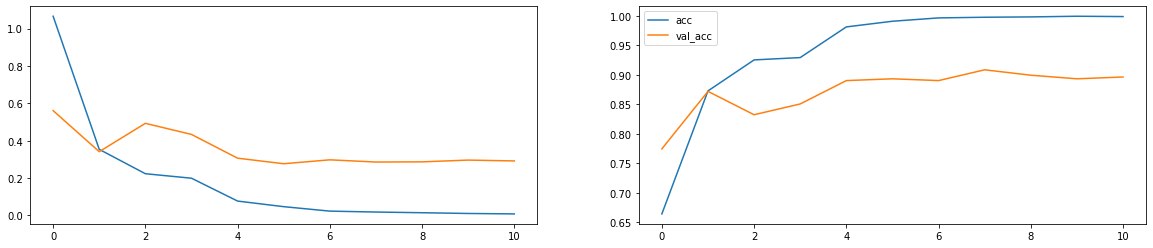

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')

axs[1].plot(history.history['categorical_accuracy'], label='acc')
axs[1].plot(history.history['val_categorical_accuracy'], label='val_acc')

plt.legend();
plt.show();

In [7]:
test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=7
)

# y_pred = net.predict(test_generator, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

filenames = test_generator.filenames
nb_samples = len(filenames)

net.evaluate_generator(test_generator, nb_samples)

Found 328 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.27637261152267456, 0.8932926654815674]